# Homework - Exploratory Data Analysis and CAPM

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import scipy.stats as stats
import statsmodels.api as sm

The firm is Citigroup Inc. (ticker = "C") and we chose to use simple percentage returns

In [4]:
# importing the data
data = pd.read_excel("./data_HW.xlsx", index_col=0)
citi =data[["C"]]
citi.head()

,C
Date,
2010-01-04,25.749702
2010-01-05,26.734247
2010-01-06,27.567324
2010-01-07,27.643055
2010-01-08,27.188667


In [6]:
# calculating simple returns
citi_rets = citi.pct_change().dropna()
citi_rets.head()

,C
Date,
2010-01-05,0.038235
2010-01-06,0.031161
2010-01-07,0.002747
2010-01-08,-0.016438
2010-01-11,0.011142


##  1. Stylized facts of financial returns
### a)

In [9]:
# Computing the mean and variance of returns
mean = citi_rets.mean()
var = citi_rets.std()**2
skew = citi_rets.skew()
kurt = citi_rets.kurt()
print(f"Mean = {mean}, Variance = {var}, Skewness = {skew}, Kurtosis = {kurt}")

Mean = C    0.000526
dtype: float64, Variance = C    0.000455
dtype: float64, Skewness = C   -0.068666
dtype: float64, Kurtosis = C    9.433231
dtype: float64


The mean of 0.000526 indicates that the average return is slightly positive but very close to zero. The variance of 0.000455 shows that the returns are tightly clustered around the mean, indicating low volatility. The skewness of -0.0687 suggests a slight left-leaning asymmetry, meaning there are slightly more negative returns than positive ones, but overall, the distribution is nearly symmetric. The kurtosis of 9.433 indicates a distribution with heavier tails and a sharper peak compared to a normal distribution, which has a kurtosis of 3. This means that extreme returns, both positive and negative, are more likely to occur than in a normal distribution. Overall, while the returns are generally stable, there is a higher probability of outliers compared to a normal distribution.

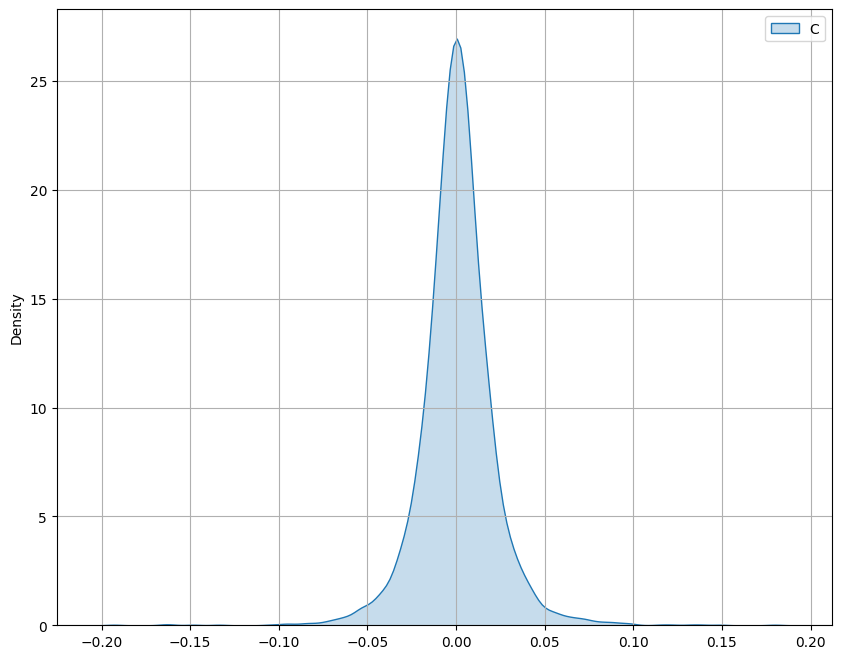

In [12]:
# plotting the distribution
plt.figure(figsize=(10,8))
sns.kdeplot(citi_rets, fill = True, color="Indigo")
plt.grid(True)
plt.show()

### b)

In [15]:
# performing the Box-Pierce test to check autocorrelation in the first 20 lags
T = citi_rets.shape[0]
confidence_level = 0.95
lags = 20
box_pierce = T*np.sum(acf(citi_rets, nlags=20)[1:]**2)
crit_value = stats.chi2.ppf(confidence_level, lags)
print(f"Box-Pierce Test = {box_pierce}")
print(f"Critical Value = {crit_value}")

Box-Pierce Test = 87.77620410991862
Critical Value = 31.410432844230918


The Box-Pierce test statistic of 87.78 is significantly higher than the critical value of 31.41. This indicates evidence of autocorrelation in the first 20 lags of the return series. This means that the returns are not independent over time and that past returns influence future returns within this time frame. This suggests that there is a predictable pattern or structure in the data, which could be exploited for forecasting or modeling purposes.

#  2. CAPM

### a) 

In [20]:
import yfinance as yf

In [22]:
ticker = "^GSPC"
sp500 = yf.download(ticker, start= citi.index[0], end=citi.index[-1])["Close"]
sp500_rets = sp500.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True



*********************100%***********************]  1 of 1 completed

In [24]:
risk_free = (yf.download("^IRX", start=citi.index[1], end=citi.index[-1])["Close"]/100)/252


*********************100%***********************]  1 of 1 completed

In [26]:
risk_free_aligned = risk_free.reindex(citi_rets.index, method="ffill")

In [28]:
sp500_rets_aligned = sp500_rets.reindex(citi_rets.index, method="ffill")

In [41]:
# After importing the data we calculate the excess returns of both citi and the sp500
market_excess = sp500_rets_aligned["^GSPC"]-risk_free_aligned["^IRX"]
market_excess = sm.add_constant(market_excess) 
market_excess.columns = ["alpha", "Market_Excess"] # Renaming the columns to better understand the summary of the regression
citi_excess = citi_rets["C"]-risk_free_aligned["^IRX"]

In [43]:
# Training the model
capm_reg = sm.OLS(citi_excess, market_excess).fit() 

### b)

In [46]:
capm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     4232.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:25:45   Log-Likelihood:                 10682.
No. Observations:                3812   AIC:                        -2.136e+04
Df Residuals:                    3810   BIC:                        -2.135e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
alpha            -0.0001      0.000     -0.621      0.535      -0.001       0.000
Market_Excess     1.4286      0.022     65.058      0.000       1.386       1.472
==============================================================================
Omnibus:                      485.935   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4731.938
Skew:                           0.230   Prob(JB):                         0.00
Kurtosis:                       8.439   Cond. No.                         92.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this CAPM regression model, β (beta) represents the sensitivity of your asset’s excess return to the excess return of the market (S&P 500 here).

A β of 1.43 means the asset is 43% more volatile than the market.

If the market's excess return increases by 1%, your asset's excess return is expected to increase by approximately 1.43% on average.

The p-value of 0.000 indicates that β is statistically significant — we can confidently say there is a relationship between market returns and asset returns.

# 3. Estimating Time-Varying Beta (Rolling Window Approach)

### A) Perform Rolling regression

In [53]:
window_size = 252
rolling_betas = []
citi_excess_values = citi_excess.values
market_excess_values = market_excess.values
for i in range(len(citi_excess) - window_size + 1): # Loop to perform the regressions over different windows
    y_window = citi_excess.iloc[i : i + window_size]  
    X_window = market_excess.iloc[i : i + window_size]
    
    X_window = sm.add_constant(X_window)
    
    model = sm.OLS(y_window, X_window).fit()
    
    rolling_betas.append(model.params.iloc[1])

rolling_betas_series = pd.Series(rolling_betas, index=citi_excess.index[window_size - 1:])

### B) Plot and interpret

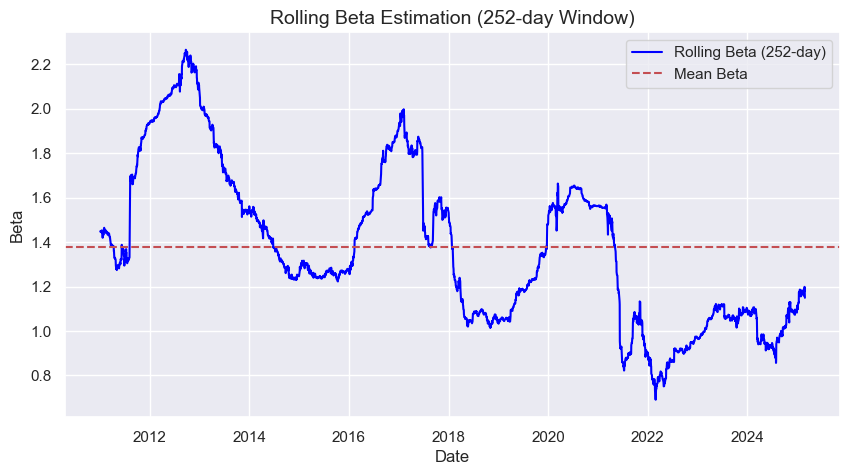

In [58]:
sns.set_theme(style="darkgrid") # Seaborn > Matplotlib
plt.figure(figsize=(10, 5))
sns.lineplot(x=rolling_betas_series.index, y=rolling_betas_series, label="Rolling Beta (252-day)", color="blue")  
plt.axhline(y=np.mean(rolling_betas_series), color='r', linestyle='--', label="Mean Beta")
plt.legend()
plt.title("Rolling Beta Estimation (252-day Window)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Beta", fontsize=12)
plt.show()

The rolling β (252-day window) shows significant variation over time, ranging from ~0.8 to over 2.2. This indicates that the asset's sensitivity to market returns is not stable.

- **2013, 2016, 2020**: High β (> 2) — the asset was more volatile than the market.
- **2018, 2021–2022**: Low β (< 1) — the asset was less sensitive to market movements.
- **2023–2025**: β is increasing — the asset’s market sensitivity is rising again.

Overall, β is time-varying, highlighting the importance of dynamic risk estimation over static CAPM assumptions.

### C) Discussion

In [62]:
sp500squared = sp500_rets_aligned**2

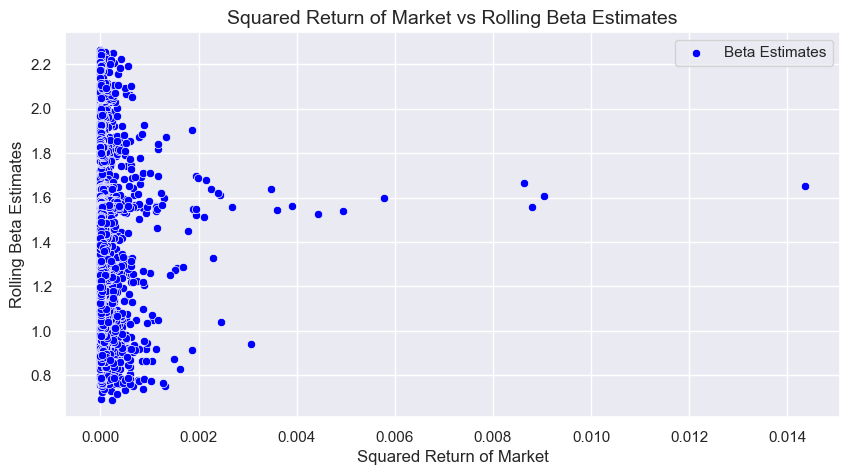

In [63]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x=sp500squared[window_size-1:].values.flatten(), y=rolling_betas_series.values.flatten(), color="blue", label="Beta Estimates")
plt.legend()
plt.title("Squared Return of Market vs Rolling Beta Estimates", fontsize=14)
plt.xlabel("Squared Return of Market", fontsize=12)
plt.ylabel("Rolling Beta Estimates", fontsize=12)
plt.show()

### Squared Market Returns vs Rolling Beta Estimates

We computed the squared daily returns of the S&P 500 index as a proxy for market volatility, and plotted them against the rolling β estimates (252-day window).

####  Observations:
- Most points are clustered around low squared returns, as large market movements are rare.
- There is **no clear linear relationship** between squared returns and beta estimates.
- For a given level of market volatility, beta estimates can vary significantly (from ~0.8 to ~2.2).
- A few extreme volatility events do not consistently correspond to higher or lower beta values.

####  Conclusion:
There is **no strong or systematic relationship** between market volatility and beta estimates. This implies that **beta is influenced by other factors**, not just daily market volatility. Dynamic beta estimation provides richer insights than assuming constant beta. While the clustering around beta 1.6 is intriguing, it warrants further investigation with additional data or different time periods to confirm whether this is a consistent pattern or a statistical anomaly
